In [42]:
import numpy as np
import matplotlib.pyplot as plt

nx, ny = 251, 81
a, b = 100, 40
dz = 0.01
mu, rho = 1.0, 1.0
Q_values = [-1, -10, -100, -200, -400]
ik, jk = 5, 10
y1, y2 = -40 * dz, 40 * dz
eps = 1e-7
imin_obs, imax_obs, jmax_obs = -ik + a, ik + a, jk + b

# Wykresy
plt.rcParams.update({
    'lines.linewidth': 2,
    'font.size': 12,
    'legend.framealpha': 0.9,
    'legend.facecolor': '#f0f0f0',
    'legend.edgecolor': 'gray'
})


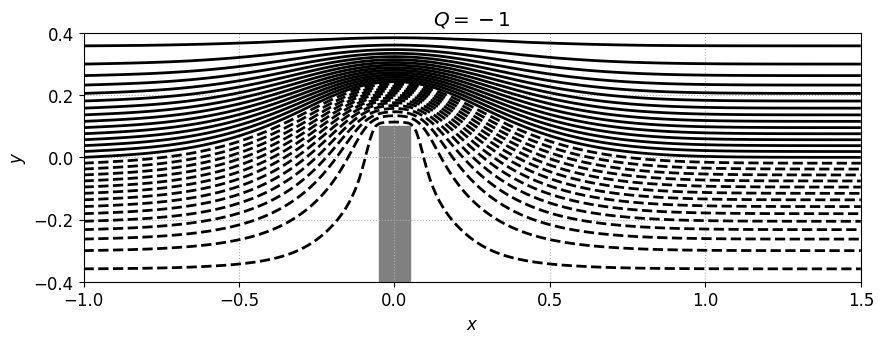

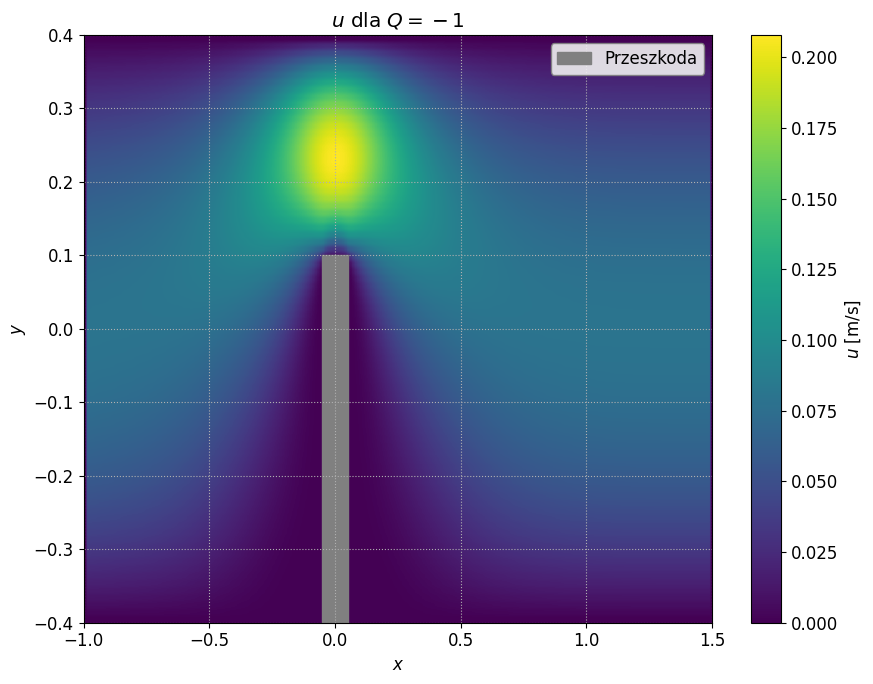

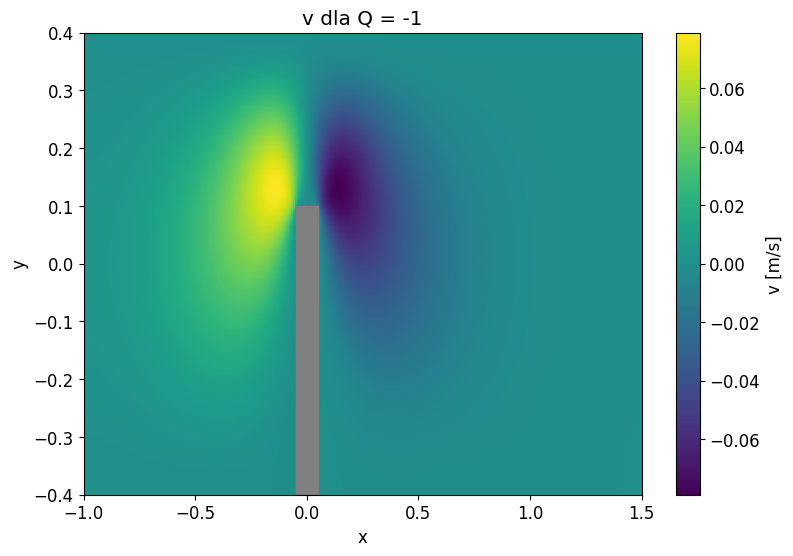

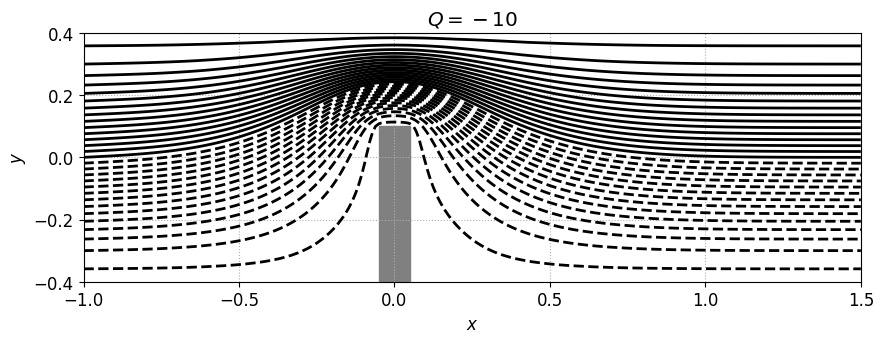

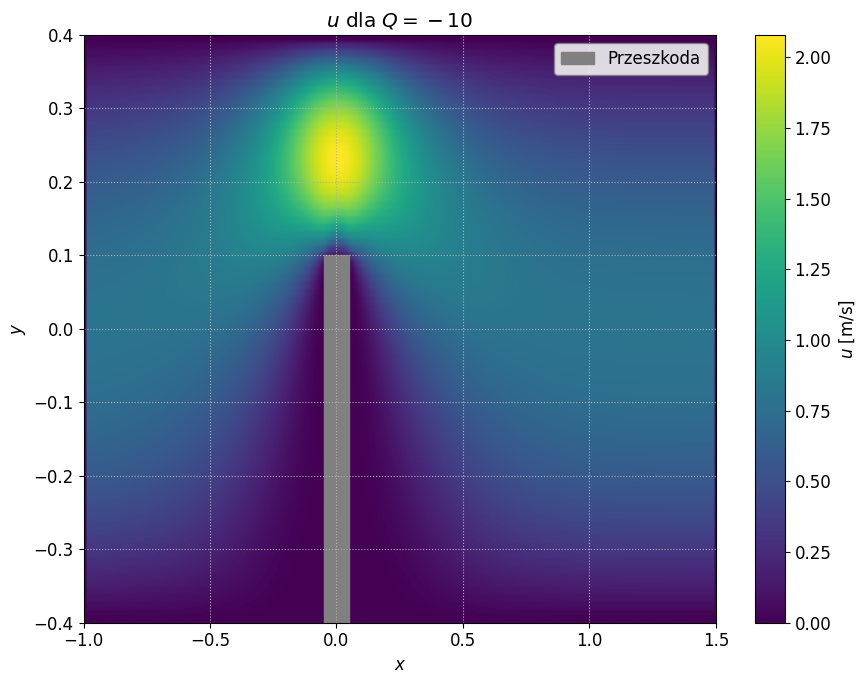

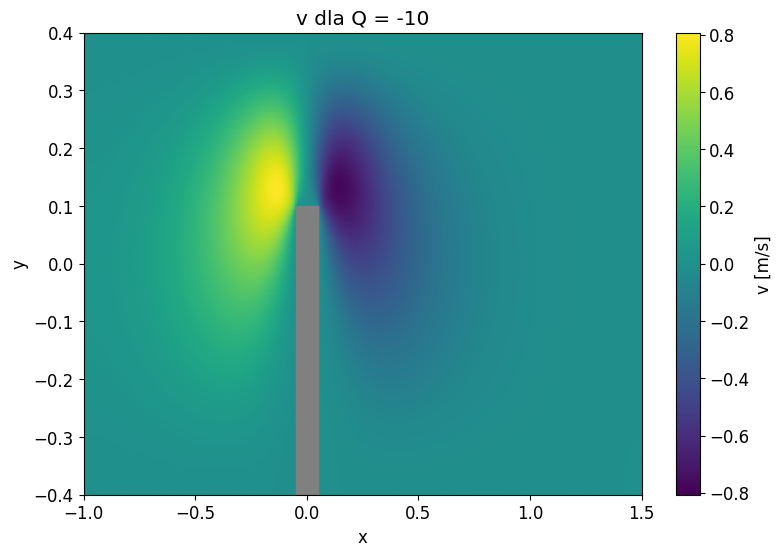

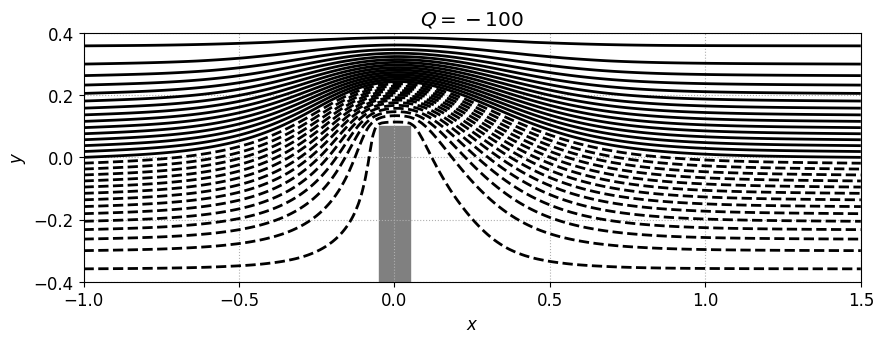

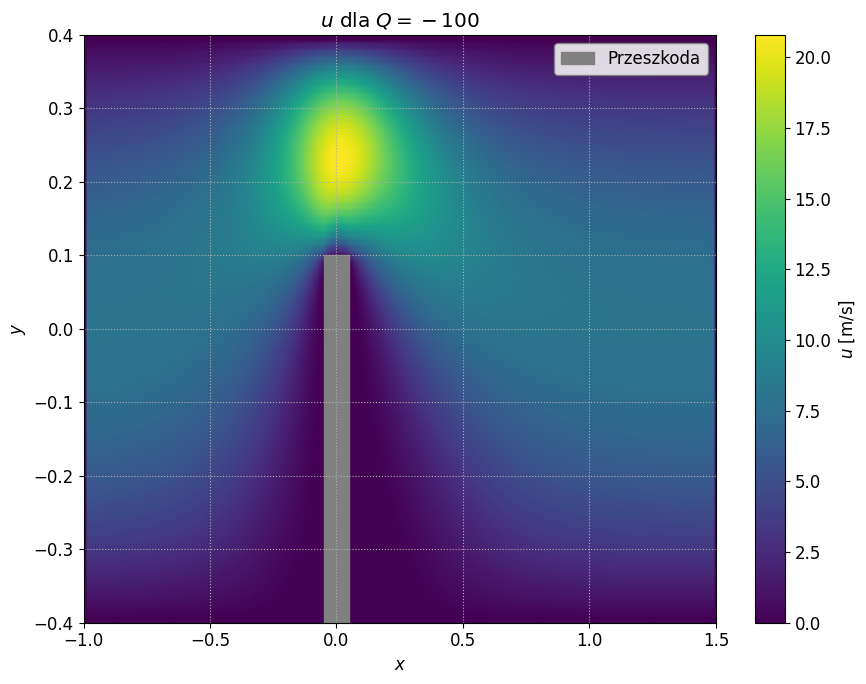

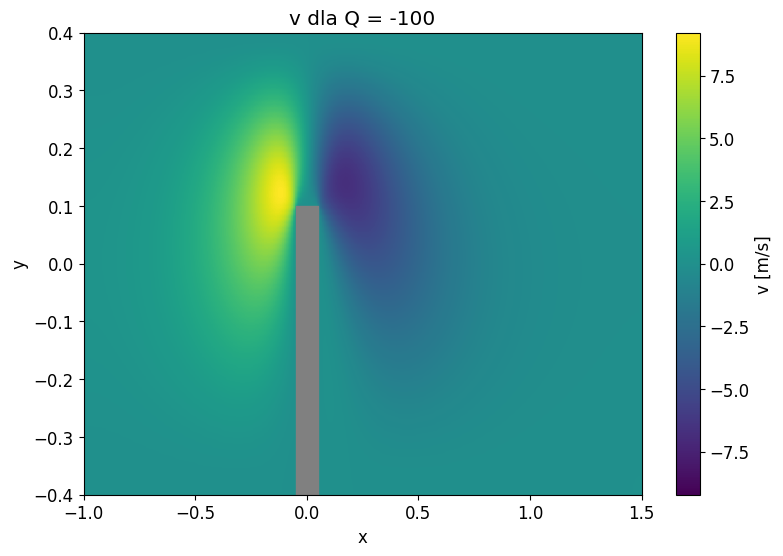

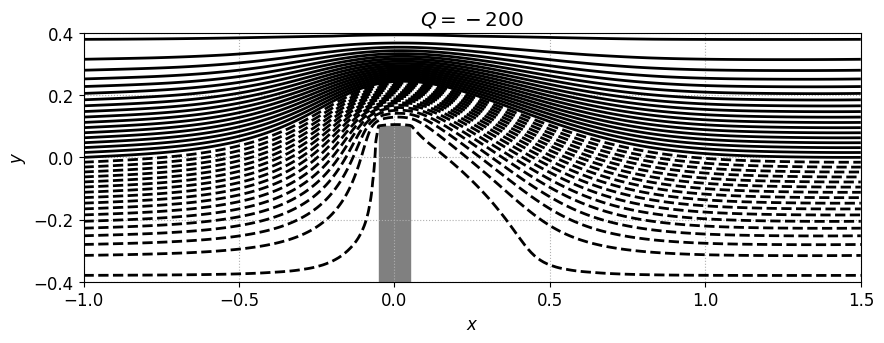

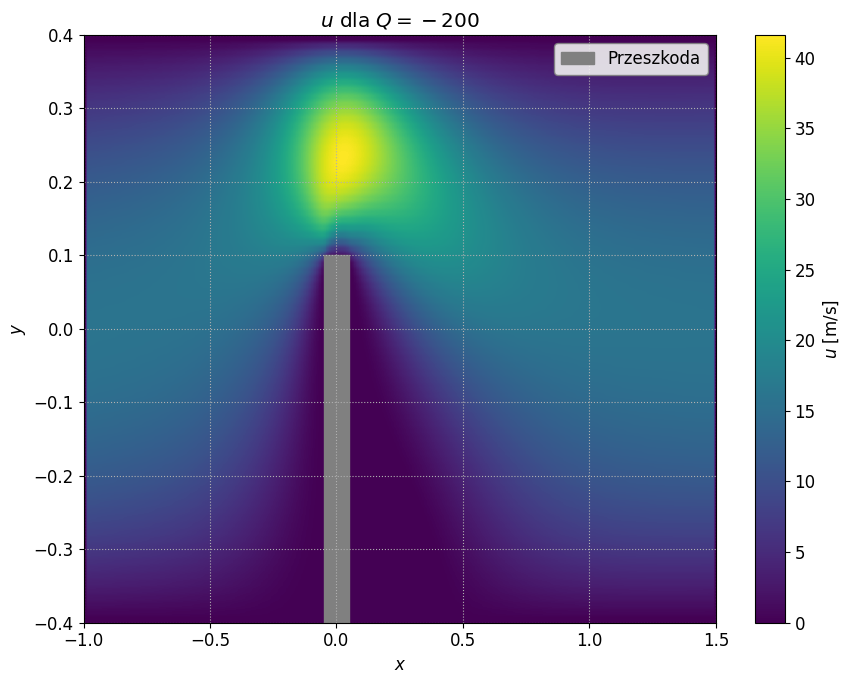

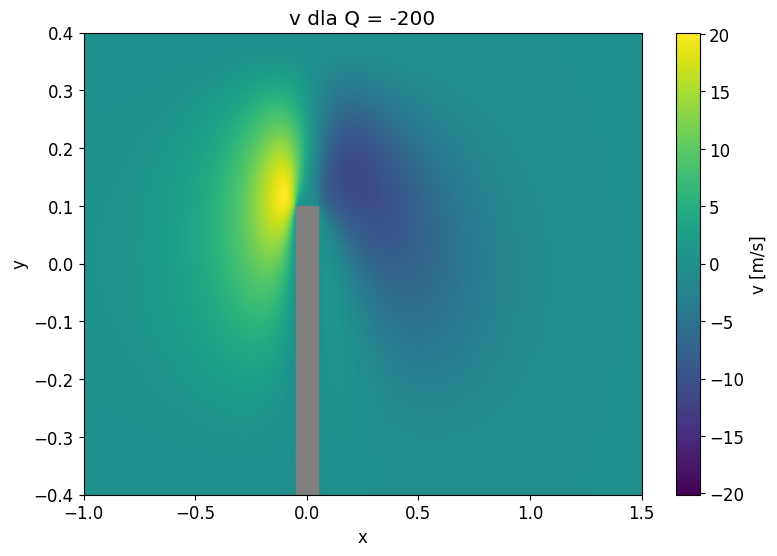

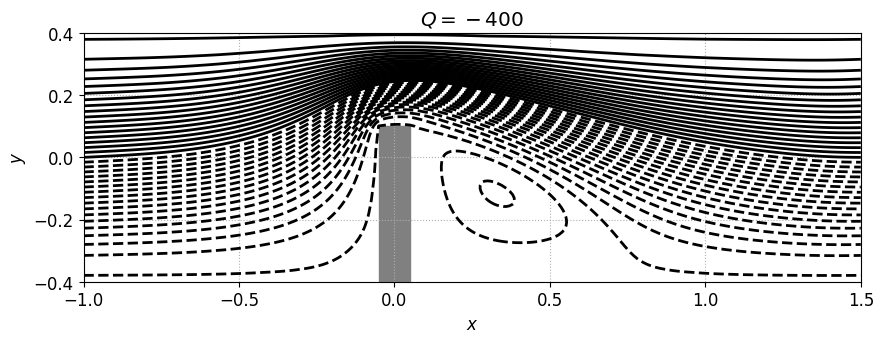

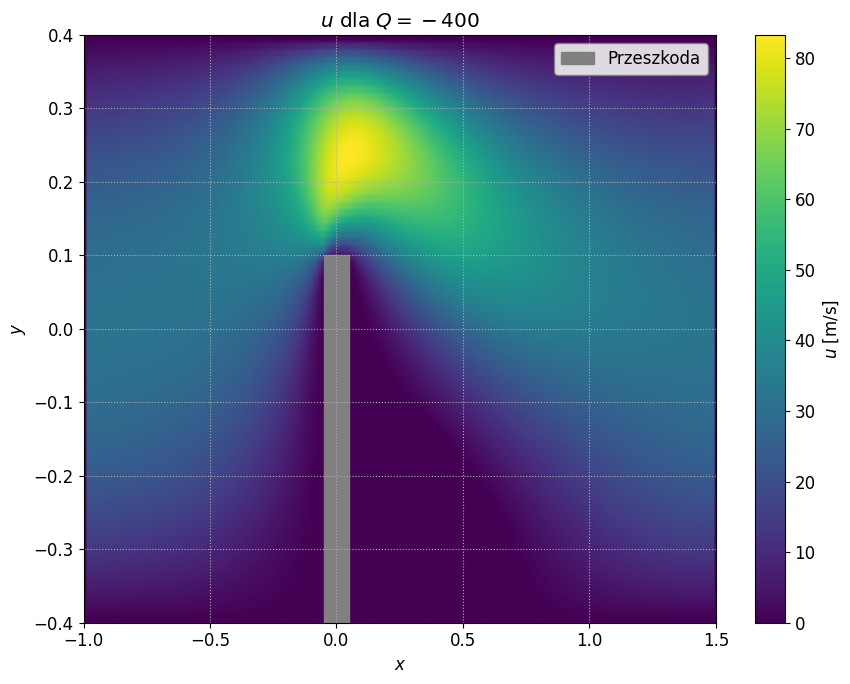

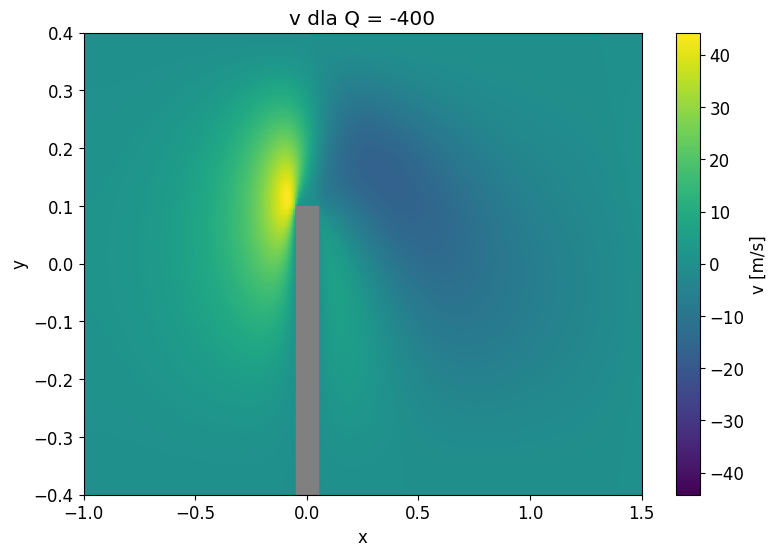

In [43]:
is_fluid = np.full((nx, ny), True, dtype=bool)
is_fluid[imin_obs:imax_obs+1, :jmax_obs+1] = False
is_fluid_interior = is_fluid[1:-1, 1:-1]

def psi_analytic(y, q_val): return (q_val / (2 * mu)) * (y**3 / 3 + y1 * y2 * y)
def dze_analytic(y, q_val): return (q_val / mu) * y

max_iter = 100000
min_iter = 500
for Q in Q_values:
    psi = np.zeros((nx, ny))
    dze = np.zeros((nx, ny))
    y_vec = (np.arange(ny) - b) * dz
    for i in range(nx):
        psi[i, :] = psi_analytic(y_vec, Q)
        dze[i, :] = dze_analytic(y_vec, Q)
    psi_bottom_val = psi_analytic(y1, Q)

    for iteration in range(max_iter):
        psi_prev = psi[50 + a, 20 + b]
        psi[:, 0] = psi_bottom_val
        psi[imin_obs:imax_obs + 1, :jmax_obs + 1] = psi_bottom_val
        dze[:, ny-1] = 2 * (psi[:, ny-2] - psi[:, ny-1]) / dz**2
        dze[imax_obs+1:, 0] = 2 * (psi[imax_obs+1:, 1] - psi[imax_obs+1:, 0]) / dz**2
        dze[:imin_obs, 0] = 2 * (psi[:imin_obs, 1] - psi[:imin_obs, 0]) / dz**2
        dze[imin_obs, :jmax_obs+1] = 2 * (psi[imin_obs-1, :jmax_obs+1] - psi[imin_obs, :jmax_obs+1]) / dz**2
        dze[imax_obs, :jmax_obs+1] = 2 * (psi[imax_obs+1, :jmax_obs+1] - psi[imax_obs, :jmax_obs+1]) / dz**2
        dze[imin_obs:imax_obs+1, jmax_obs] = 2 * (psi[imin_obs:imax_obs+1, jmax_obs+1] - psi[imin_obs:imax_obs+1, jmax_obs]) / dz**2

        psi_new = psi.copy()
        dze_new = dze.copy()

        psi_update = 0.25 * (psi[2:, 1:-1] + psi[:-2, 1:-1] + psi[1:-1, 2:] + psi[1:-1, :-2] - dze[1:-1, 1:-1] * dz**2)
        term_psi_y = psi[1:-1, 2:] - psi[1:-1, :-2]
        term_dze_x = dze[2:, 1:-1] - dze[:-2, 1:-1]
        term_psi_x = psi[2:, 1:-1] - psi[:-2, 1:-1]
        term_dze_y = dze[1:-1, 2:] - dze[1:-1, :-2]
        dze_update = 0.25 * (dze[2:, 1:-1] + dze[:-2, 1:-1] + dze[1:-1, 2:] + dze[1:-1, :-2]) - (rho / (16 * mu)) * (term_psi_y * term_dze_x - term_psi_x * term_dze_y)

        psi_new[1:-1, 1:-1][is_fluid_interior] = psi_update[is_fluid_interior]
        dze_new[1:-1, 1:-1][is_fluid_interior] = dze_update[is_fluid_interior]

        psi, dze = psi_new, dze_new

        if iteration > min_iter:
            delta = abs(psi[50 + a, 20 + b] - psi_prev)
            if delta < eps and iteration > 1000:
                break

    u = np.zeros_like(psi)
    v = np.zeros_like(psi)
    u[1:-1, 1:-1] = (psi[1:-1, 2:] - psi[1:-1, :-2]) / (2 * dz)
    v[1:-1, 1:-1] = -(psi[2:, 1:-1] - psi[:-2, 1:-1]) / (2 * dz)
    x_coords = (np.arange(nx) - a) * dz
    y_coords = (np.arange(ny) - b) * dz

    plt.figure(figsize=(9, 7))
    ax1 = plt.gca()
    ax1.contour(x_coords, y_coords, psi.T, levels=40, colors='k', linewidths=2)
    ax1.fill_between(x_coords[imin_obs:imax_obs+1], y1, y_coords[jmax_obs], color='gray')
    ax1.set_title(f'$Q = {Q}$')
    ax1.set_xlabel('$x$')
    ax1.set_ylabel('$y$')
    ax1.set_aspect('equal', adjustable='box')
    ax1.grid(True, linestyle=':', linewidth=0.8)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(9, 7))
    ax2 = plt.gca()
    vmax_u = np.max(np.abs(u))
    im_u = ax2.imshow(u.T, origin='lower', aspect='auto', cmap='viridis',
                    extent=[x_coords[0], x_coords[-1], y1, y2],
                    vmin=0, vmax=vmax_u)
    ax2.fill_between(x_coords[imin_obs:imax_obs+1], y1, y_coords[jmax_obs], color='gray', label='Przeszkoda')
    ax2.set_title(f'$u$ dla $Q = {Q}$')
    ax2.set_xlabel('$x$')
    ax2.set_ylabel('$y$')
    ax2.grid(True, linestyle=':', linewidth=0.8)
    ax2.legend(loc='best')
    plt.colorbar(im_u, ax=ax2, label='$u$ [m/s]')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(9, 6))
    ax3 = plt.gca()
    vmax_v = np.max(np.abs(v))
    im_v = ax3.imshow(v.T, origin='lower', aspect='auto', cmap='viridis', extent=[x_coords[0], x_coords[-1], Y1, Y2], vmin=-vmax_v, vmax=vmax_v)
    ax3.fill_between(x_coords[I_MIN_OBS:I_MAX_OBS+1], Y1, y_coords[J_MAX_OBS], color='gray')
    ax3.set_title(f'v dla Q = {Q}')
    ax3.set_xlabel('x')
    ax3.set_ylabel('y')
    plt.colorbar(im_v, ax=ax3, label='v [m/s]')
    plt.show()
